# Importing data


In [1]:
import numpy as np
import os 
import tensorflow as tf
import mneflow      

## 1. from MNE epochs

#### If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [2]:
import mne
from mne.datasets import multimodal

print(__doc__)

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

#event_id = {}
cond = raw.acqparser.get_condition(raw, None)
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)

Automatically created module for IPython interactive environment
Opening raw data file /m/home/home6/62/zubarei1/unix/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
Current compensation grade : 0
118 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 7)
7 projection items activated
129 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 7)
7 projection 

In [9]:
#Specify import options
import_opt = dict(savepath='/m/nbe/scratch/braindata/izbrv/detection_data/tfr/', #path to where the TFR files will be saved
           out_name='mne_sample_epochs', #name of TFRecords files
           input_type='epochs', #can also be "epochs"
           picks={'meg':'grad'}, #used only if input_type is mne.epochs.Epochs or path to saved '*-epo.fif'
           scale=True, #apply baseline_scaling?
           crop_baseline=True,
           bp_filter = (1.,45.),
           decimate = 2,
           scale_interval=78, #baseline
           savebatch=8, # number of input files per TFRecord file           
           save_orig=False, # whether to produce separate TFR-file for inputs in original order
           val_size=0.1)

meta = mneflow.produce_tfrecords(epochs,**import_opt)
#a copy of meta is also saved to savepath/meta.pkl so it can be restored at any time

del meta
meta = mneflow.load_meta(import_opt['savepath'])


processing epochs
labels (940,)
(940, 204, 142)
Saving TFRecord# 0


In [ ]:
#print([c['event_id'] for c in cond])

Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files
e.g. this will work

#epochs.save('test_saved_epochs.fif')
#meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)

if the first argument is str this function can also accept *.mat or *.npz format
e.g.

#data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
#filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
#meta = mneflow.produce_tfrecords(filenames,**opt)

In this case, specify iput_type='array', and also provide array_keys keyword argument

#e.g. array_keys={'X':'my_data_samples','y':'my_labels'}
#note that "picks" works only for mne epochs

# Choose from already implemented models

In [20]:
#specify model parameters
params = dict(l1_lambda=3e-4,
              learn_rate=3e-4,
              dropout = .5,
              patience = 5,# patientce for early stopping
              min_delta = 5e-6,
              test_upd_batch = 20,#pseudo-real time test batch size
              n_epochs = 1000, #total training epochs
              eval_step = 25, #evaluate validation loss each 10 epochs
              n_batch = 200,
              #these are specific to LF-CNN]
              n_ls=32, #number of latent factors
              nonlin_in = tf.identity, #input layer activation for var-cnn and lf-cnn
              nonlin_hid = tf.nn.relu, #convolution layer activation for var-cnn and lf-cnn
              nonlin_out = tf.identity, #output layer activation for var-cnn and lf-cnn
              filter_length=32, #convolutional filter length for var-cnn and lf-cnn
              pooling = 6, #convlayer pooling factor for var-cnn and lf-cnn
              stride = 1, #stride parameter for convolution filter
              ) #training batch size) 

#specify the path to store the saved model
model_path = '/m/nbe/scratch/braindata/izbrv/detection_data/tfr/'

model = mneflow.models.LFCNN(meta,params,model_path)

<DatasetV1Adapter shapes: {X: (204, 142), y: ()}, types: {X: tf.float32, y: tf.int64}>
<DatasetV1Adapter shapes: ((204, 142), ()), types: (tf.float32, tf.int64)>
lf-conv _init
dense _init
Initialization complete!


In [21]:
#train the model
from time import time
start = time()
model.train()
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

epoch 0, train_loss 3.57402, train acc 0.0652174 val loss 3.4016, val acc 0.0851064
epoch 25, train_loss 2.08, train acc 0.565217 val loss 2.54234, val acc 0.297872
epoch 50, train_loss 0.910099, train acc 0.913043 val loss 1.43828, val acc 0.638298
epoch 75, train_loss 0.781816, train acc 0.847826 val loss 1.31416, val acc 0.585106
epoch 100, train_loss 0.430225, train acc 0.934783 val loss 0.973251, val acc 0.734043
epoch 125, train_loss 0.318039, train acc 1 val loss 0.872959, val acc 0.765957
epoch 150, train_loss 0.3044, train acc 1 val loss 0.864657, val acc 0.765957
epoch 175, train_loss 0.269057, train acc 1 val loss 0.593608, val acc 0.893617
epoch 200, train_loss 0.349273, train acc 0.978261 val loss 0.664757, val acc 0.840426
*
epoch 225, train_loss 0.243643, train acc 1 val loss 0.774618, val acc 0.840426
*
epoch 250, train_loss 0.25827, train acc 1 val loss 0.962042, val acc 0.755319
*
epoch 275, train_loss 0.251242, train acc 1 val loss 0.758858, val acc 0.851064
*
epoch 

In [24]:
#evaluate performance
#TODO: add across-subject example
#test_accs = model.evaluate_performance(meta['orig_paths'], batch_size=120)
#prt_test_acc, prt_logits = model.evaluate_realtime(meta['orig_paths'], batch_size=120, step_size=params['test_upd_batch'])
#results = {'val_acc':model.v_acc[0], 'test_init':np.mean(test_accs), 'test_upd':np.mean(prt_test_acc), 'sid':meta['architecture']} # 'train_time':stop,

Trained in 748.68s


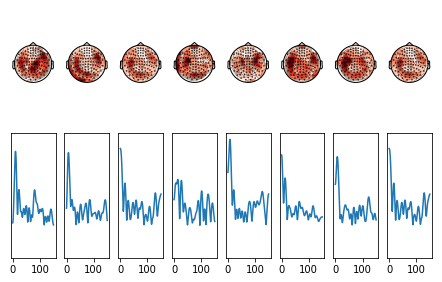

/u/62/zubarei1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [28]:

model.compute_patterns(output='patterns')
#explore output layer weights
#f = model.plot_out_weihts()
#explore informative spatial patterns(LF-CNN only)
#TODO: Fix visualizations
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', spectra=True, scale=False)

# Specify your own neural network

In [30]:
params = dict(l1_lambda=3e-4,
              learn_rate=3e-4,
              dropout = .5,
              patience = 5,# patientce for early stopping
              min_delta = 5e-6,
              test_upd_batch = 20,#pseudo-real time test batch size
              n_epochs = 1000, #total training epochs
              eval_step = 25, #evaluate validation loss each 10 epochs
              n_batch = 200) #training batch size) 

from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.constraints import max_norm

class MyNetwork(mneflow.models.Model):
    #override the computational graph
    def _build_graph(self):
        self.h_params['architecture'] = 'my_own'
        input_main   = self.X
        flatten      = Flatten()(input_main)
        dense        = Dense(self.h_params['n_classes'], kernel_constraint = max_norm(0.5))(flatten)
        y_pred      = Activation('softmax')(dense)
        return y_pred
    
m2 = MyNetwork(meta,params,model_path)
m2.train()

# #evaluate performance
# test_accs = m2.evaluate_performance(meta['orig_paths'], batch_size=120)

<DatasetV1Adapter shapes: {X: (204, 142), y: ()}, types: {X: tf.float32, y: tf.int64}>
<DatasetV1Adapter shapes: ((204, 142), ()), types: (tf.float32, tf.int64)>
Initialization complete!
epoch 0, train_loss 2.96028, train acc 0.652174 val loss 2.90475, val acc 0.659574
epoch 25, train_loss 1.85661, train acc 1 val loss 2.05819, val acc 0.829787
epoch 50, train_loss 1.50525, train acc 1 val loss 1.70533, val acc 0.829787
epoch 75, train_loss 1.33028, train acc 1 val loss 1.5272, val acc 0.840426
epoch 100, train_loss 1.27517, train acc 1 val loss 1.47034, val acc 0.851064
epoch 125, train_loss 1.27475, train acc 1 val loss 1.46769, val acc 0.861702
epoch 150, train_loss 1.27474, train acc 1 val loss 1.46592, val acc 0.87234
epoch 175, train_loss 1.27473, train acc 1 val loss 1.46452, val acc 0.861702
epoch 200, train_loss 1.27472, train acc 1 val loss 1.4634, val acc 0.861702
epoch 225, train_loss 1.27472, train acc 1 val loss 1.46252, val acc 0.861702
epoch 250, train_loss 1.27472, tra

#TODO: across-subject/leave-one-subject-out example